In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import drive, files
import networkx as nx

In [2]:
# use to connect to Google Drive if running on Google Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# point to your project directory
endo_dir = '/content/drive/MyDrive/endometriosis/'

In [4]:
# replace with the name of your dataset file
dataset_file = os.path.join(endo_dir, 'data','endo+endometriosis.pkl')

data_df = pd.read_pickle(dataset_file).drop(columns=['flair', 'created_utc', 'url', 'subreddit'])
data_df['year'] = [int(str(x).split('-')[0]) for x in data_df.time]
print(len(data_df))
data_df[:1]

392087


,author,id,type,text,link_id,parent_id,time,year
0,endogirl,Endo_c3efp47_comment,comment,Soy is a no go as it increases estrogen in you...,t3_mrkjh,t1_c39qhd9,2012-01-06 06:44:29,2012


In [5]:
types = {'post': 't3', 'comment': 't1'}

In [6]:
# create id column in the reddit format
reddit_ids = []
for our_id in data_df.id:
  sub, alphanumeric, typ = our_id.split('_')
  reddit_id  = f'{types[typ]}_{alphanumeric}'
  reddit_ids.append(reddit_id)

data_df['reddit_id'] = reddit_ids
data_df[:1]

,author,id,type,text,link_id,parent_id,time,year,reddit_id
0,endogirl,Endo_c3efp47_comment,comment,Soy is a no go as it increases estrogen in you...,t3_mrkjh,t1_c39qhd9,2012-01-06 06:44:29,2012,t1_c3efp47


In [30]:
def make_barplot(_df, _type, _reason, _measure):

  plt.figure(figsize=(7, 5))
  if _type == 'Comments':
    _color = 'Oranges'
  else:
    _color = 'Blues'

  ax = sns.barplot(data=_df, x='Year', y=_measure, hue='Year', legend=False,
                  palette=sns.color_palette(_color, len(_df.index)),
                  edgecolor='white',
                  errorbar=None)
  for container in ax.containers:
    for v in container:
      if _measure == 'Counts':
        labels = [f'{round(v.get_height())}' for v in container]
      elif _measure == 'Percentage':
        labels = [f'{round(v.get_height(), 2)}' if not np.isinf([v.get_height()])[0] else 'Inf' for v in container]
      ax.bar_label(container, labels=labels, padding=3)

  # add grid
  ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
  #plt.xticks(rotation=45, ha='right')
  plt.tick_params(left=False)  # remove the ticks

  # Remove top, left, right border
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)

  if _measure == 'Counts':
    _title = f'Number of {_reason} {_type} Over Time'
  else:
    _title = f'Ratio of {_reason} {_type} Over Time'
  plt.title(_title)
  #plt.savefig(os.path.join(endo_dir, 'data', f'{_type}_years.png'), dpi = 300, bbox_inches = "tight")
  plt.show()

## Missing posts

In [8]:
# collect all the post ids comments are linked to in the dataset
comment_link_ids = data_df[data_df['type'] == 'comment'].link_id.unique()

In [9]:
# collect all the post ids of the posts in the dataset
post_ids = data_df[data_df['type']=='post'].reddit_id.unique()
post_ids_d = {} # make a dictionary for efficiency
for id in post_ids:
    post_ids_d[id] = 1

In [10]:
# collect all the ids that are not in the dataset: they are the ids of the missing posts
%%time
missing_posts = []

idx = 0
for post_id in comment_link_ids:
  if post_id not in post_ids_d:
    missing_posts.append(post_id)

  idx += 1
  if idx % 10000 == 0:
    print(idx)

10000
20000
30000
40000
CPU times: user 21.4 ms, sys: 0 ns, total: 21.4 ms
Wall time: 22 ms


In [11]:
# create df of missing posts
link_ids = data_df[data_df['type']=='comment'][['link_id', 'year']].groupby('link_id').mean().copy()
link_ids['year'] = link_ids['year'].astype(int)
missing_posts_df = link_ids.loc[missing_posts].reset_index()

In [12]:
# create df of number of missing posts per year
missing_posts_year = missing_posts_df.groupby('year').count().reset_index().rename(columns = {"year":"Year", "link_id":"Counts"})[['Year', 'Counts']]
missing_posts_year = missing_posts_year.sort_values('Year')

In [13]:
# create df of number of posts in the dataset per year
posts_year_df = data_df.loc[data_df['type']=='post'].groupby('year').count().reset_index().rename(columns = {"year":"Year", "id":"Counts"})[['Year', 'Counts']]
posts_year_df.loc[len(posts_year_df.index)] = [2013, 0]
posts_year_df = posts_year_df.sort_values('Year')

In [23]:
# merge the two posts dfs to find percentage
merged_posts_year = pd.merge(posts_year_df, missing_posts_year, left_on='Year', right_on='Year')
merged_posts_year['Percentage'] = merged_posts_year['Counts_y']/merged_posts_year['Counts_x']
merged_posts_year.replace([np.inf], 100, inplace=True)

In [16]:
len(missing_posts)

10151

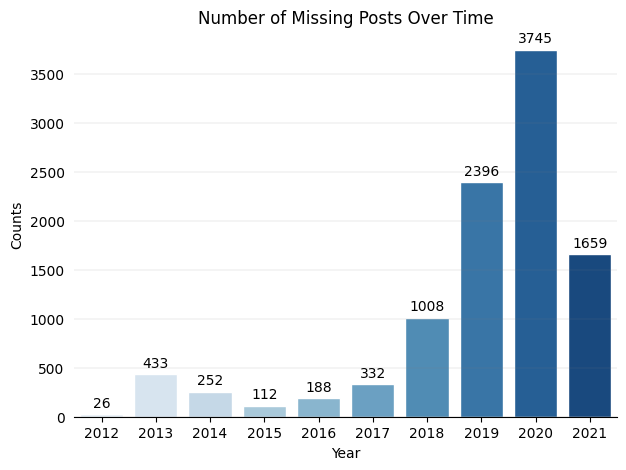

In [31]:
make_barplot(missing_posts_year, 'Posts', 'Missing', 'Counts')

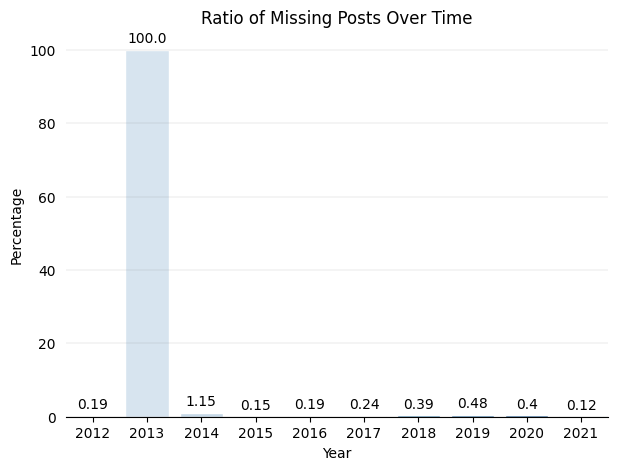

In [32]:
make_barplot(merged_posts_year, 'Posts', 'Missing', 'Percentage')

## Removed comments

In [33]:
# create df of all comments that are in the dataset but the user wanted removed
indexes = []
for index, row in data_df.iterrows():
  if row['text'] == '[deleted]' or row['text'] == '[removed]':
    indexes.append(index)
removed_comments = data_df.iloc[indexes].copy()
print(len(removed_comments))
removed_comments_year = removed_comments.groupby('year').count().reset_index().rename(columns = {"year":"Year", "id":"Counts"})[['Year', 'Counts']]

4210


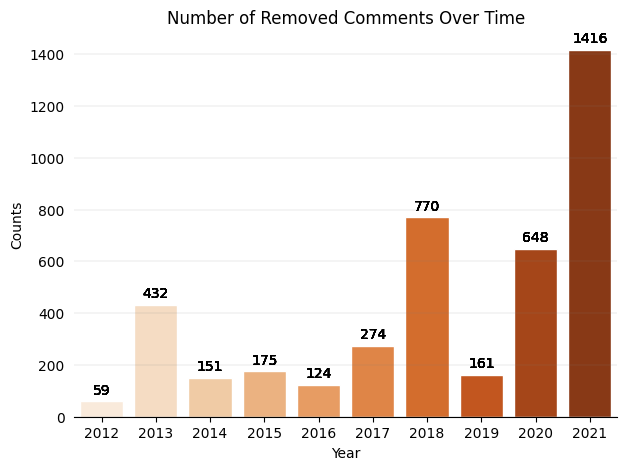

In [ ]:
make_barplot(removed_comments_year, 'Comments', 'Removed', 'Counts')

In [ ]:
# create df of number of comments in the dataset per year
comments_year_df = data_df.loc[data_df['type']=='comment'].groupby('year').count().reset_index().rename(columns = {"year":"Year", "id":"Counts"})[['Year', 'Counts']]
comments_year_df = comments_year_df.sort_values('Year')

In [ ]:
# merge the two dfs to find percentage
merged_comments_year = pd.merge(comments_year_df, removed_comments_year, left_on='Year', right_on='Year')
merged_comments_year['Percentage'] = merged_comments_year['Counts_y']/merged_comments_year['Counts_x']

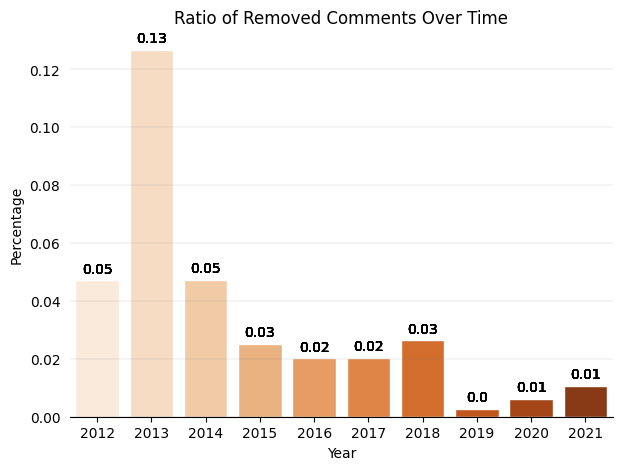

In [ ]:
make_barplot(merged_comments_year, 'Comments', 'Removed', 'Percentage')

# Missing comments

In [ ]:
# collect all the comment ids that other comments are linked to in the dataset
comment_parent_ids = [x for x in data_df[data_df['type'] == 'comment'].parent_id.unique() if 't3_' not in x]

In [ ]:
# collect all the comment ids in the dataset
comment_ids = data_df[data_df['type'] == 'comment'].reddit_id.unique()
comment_ids_d = {}
for id in comment_ids:
    comment_ids_d[id] = 1

In [ ]:
# collect all the comment ids that are not in the dataset: they are the ids of the missing comments
%%time
missing_comments = []

idx = 0
for parent_id in comment_parent_ids:
  if parent_id not in comment_ids_d:
    missing_comments.append(parent_id)

  idx += 1
  if idx % 10000 == 0:
    print(idx)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
CPU times: user 149 ms, sys: 1.01 ms, total: 150 ms
Wall time: 159 ms


In [ ]:
len(missing_comments)

4128

In [ ]:
# create df of missing comments
parent_ids = data_df[data_df['type']=='comment'][['parent_id', 'year']].groupby('parent_id').mean().copy()
parent_ids['year'] = parent_ids['year'].astype(int)
missing_comments_df = parent_ids.loc[missing_comments].reset_index()

In [ ]:
# create df of number of missing comments per year
missing_comments_year = missing_comments_df.groupby('year').count().reset_index().rename(columns = {"year":"Year", "parent_id":"Counts"})[['Year', 'Counts']]
missing_comments_year = missing_comments_year.sort_values('Year')

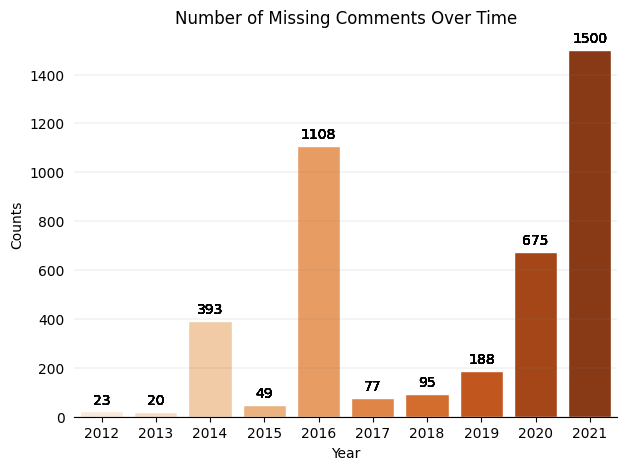

In [ ]:
make_barplot(missing_comments_year, 'Comments', 'Missing', 'Counts')

In [ ]:
# merge with df of comments per year to find the percentage
merged_comments_year = pd.merge(comments_year_df, missing_comments_year, left_on='Year', right_on='Year')
merged_comments_year['Percentage'] = merged_comments_year['Counts_y']/merged_comments_year['Counts_x']

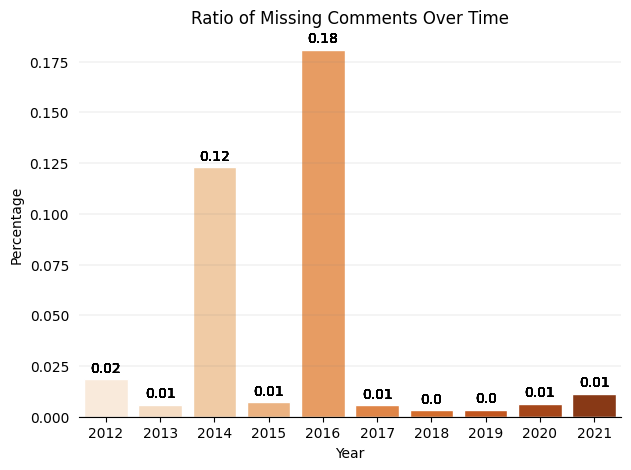

In [ ]:
make_barplot(merged_comments_year, 'Comments', 'Missing', 'Percentage')